## Avaliação em holdouts - Amazon Digital Music

In [1]:
import os
import sys
sys.path.append(os.path.abspath('') + '/..')

In [2]:
from data import ImplicitData, getBucketsHoldouts
from plot_utils import lineplot_recallxholdout, recall_heatmap
from dataset_evaluation_utils import *
from recommenders_implicit import ISGD, RAISGD, RSISGD  # ISGD framework, BISGD,
from eval_implicit import EvaluateHoldouts, EvaluateAndStore, EvalPrequential # EvaluateAndStore para guardar estados do modelo e holdouts, a avaliação prequencial de ratings implicitos é opcional, , EvalHoldout

import itertools

from datetime import datetime
import joblib
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

___
## BWT FWT

ACC, BWT, e FWT - Lopez-Paz e Ranzato GEM

In [3]:
def avg_recall(results_matrix): # Lopez-Paz e Ranzato GEM 2017
    return np.mean( np.diag(results_matrix) )

def compute_BWT_lopes_ranzato(results_matrix): # Lopez-Paz e Ranzato GEM 2017
    BWT = []
    n_checkpoints = results_matrix.shape[0]
    for T in range(1, n_checkpoints): # 1 means holdout 2, 2 means 3, so on
        Rti = results_matrix.iloc[T, 0:T] # get models performances' on previous holdouts
        Rii = np.diag(results_matrix)[0:T] # get models performances' on their closest holdouts (diagonal)
        E = sum( Rti - Rii ) # future models performances' - performances' of models closest to holdouts (diagonal)
        BWT.append( E/T ) # store average BWT for model
    return BWT, np.mean( BWT ) # return BWT and average BWT for all models

def compute_BWT_rodrigues(results_matrix): # Díaz-Rodriguez et al. 2018
    diff = []
    n_checkpoints = results_matrix.shape[0]
    for i in range(1, n_checkpoints): # 1 means holdout 2, 2 means 3, so on
        for j in range(i):
            Rij = results_matrix.iloc[i,j] # get models performances' on previous holdouts
            Rjj = results_matrix.iloc[j,j] # get models performances' on their closest holdouts (diagonal)
            # print(Rij, Rjj)
            diff.append( Rij - Rjj ) # future models performances' - performances' of models closest to holdouts (diagonal)
            # print(diff)
    BWT = sum(diff) / ( n_checkpoints*(n_checkpoints-1) / 2 ) # store average BWT for model
    return BWT, diff # return BWT and average BWT for all models

def compute_FWT_rodrigues(results_matrix): # Díaz-Rodriguez et al. 2018
    upper_tri = results_matrix.to_numpy()[np.triu_indices(results_matrix.shape[0], k=1)]
    return np.mean(upper_tri)


def grid_search(model, stream, random_seed = 10, interleaved=10):    
    num_factors = [50, 100, 150, 200]
    num_iter = [1, 2, 5, 8]
    learn_rate = [0.01, 0.05, 0.1, 0.25, 0.5]
    regularization = [0.01, 0.05, 0.1, 0.25, 0.5]
    num_nodes = [1, 2, 4, 8, 16]
    grid = [num_factors, num_iter, learn_rate, regularization, num_nodes]
    grid = list(itertools.product(*grid))
    results = []
    for i, hp in enumerate(grid):
        print(((i*100)/len(grid)), '%')
        empty_stream = ImplicitData([], [])
        nf, ni, lr, reg, nn = hp
        m = model(empty_stream, nf, ni, lr, reg, reg, random_seed)
        e = EvalPrequential(m, stream, metrics = ["Recall@N"])
        result = e.Evaluate(start_eval=0, count=stream.size, interleaved=interleaved)
        results.append( np.mean(result['Recall@N']) )
    return grid, results  

In [39]:
def get_namepaths(sample_year_month,
                  interval_type,
                  dump_filename,
                  use_data_unique_users,
                  to_grid_search,
                  num_factors,
                  num_iter,
                  learn_rate,
                  regularization,
                  random_seed):
    
    sample_year_month_start = sample_year_month[0][0]
    sample_year_month_end = sample_year_month[1][0]
    sample_str = str(sample_year_month_start)+'_until_'+str(sample_year_month_end)


    dataset_name = 'sample_'+sample_str+'_amazon_digimusic'
    user_col = 'user_id'
    item_col = 'item_id'

    output_path = 'output/'+dump_filename+'/'

    data_path = output_path+''+dataset_name+'.csv'

    frequent_users_path = output_path+'sample_'+sample_str+'_frequent_users.joblib' 


    if interval_type == 'Q':
        intervals_path = output_path+'sample_'+sample_str+'_trimestres.joblib'
        bucket_freq =  'quarterly'
    elif interval_type == 'S':
        intervals_path = output_path+'sample_'+sample_str+'_semestres.joblib'
        bucket_freq = 'semesterly'
    else:
        # interval_type == 'M'
        intervals_path = None
        bucket_freq = 'monthly'


    buckets_path = output_path+'sample_'+sample_str+'_'+bucket_freq+'_buckets.joblib'
    holdouts_path = output_path+'sample_'+sample_str+'_'+bucket_freq+'_holdouts.joblib'

    results_matrix_path = output_path+''+dataset_name+' '+bucket_freq+'_bucket ISGD results.csv'

    recall_heatmap_title = 'Recall@20 for ISGD checkpoints across Holdouts ('+sample_str+'_'+bucket_freq+') - Amazon Digital Music'
    recall_heatmap_path = 'images/heatmaps/'+dump_filename+'/'+dataset_name+' '+bucket_freq+'_bucket ISGD heatmap.png'

    incrementalTraining_time_record_path = output_path+''+dataset_name+' '+bucket_freq+'_bucket ISGD training time.joblib'
    evaluateHoldouts_time_record_path =  output_path+''+dataset_name+' '+bucket_freq+'_bucket ISGD eval time.joblib'

    return {'sample_str': sample_str, 
            'dataset_name': dataset_name,
            'user_col': user_col, 
            'item_col': item_col,
            'output_path': output_path, 
            'data_path': data_path,
            'use_data_unique_users': use_data_unique_users,
            'frequent_users_path':frequent_users_path,
            'to_grid_search':to_grid_search,
            'num_factors': num_factors,
            'num_iter': num_iter,
            'learn_rate': learn_rate,
            'regularization': regularization,
            'random_seed': random_seed,
            'interval_type': interval_type,
            'intervals_path': intervals_path,
            'bucket_freq': bucket_freq,
            'buckets_path': buckets_path,
            'holdouts_path': holdouts_path,
            'results_matrix_path': results_matrix_path,
            'recall_heatmap_title': recall_heatmap_title,
            'recall_heatmap_path': recall_heatmap_path,
            'incrementalTraining_time_record_path': incrementalTraining_time_record_path,
            'evaluateHoldouts_time_record_path': evaluateHoldouts_time_record_path}

def load_data_print_info(data_path):
    data = pd.read_csv(data_path)

    print('data.shape', data.shape)
    print('number of users', data.user_id.nunique())
    print('number of items', data.item_id.nunique())
    print('number of duplicated user-item interactions', data[['user_id', 'item_id']].duplicated().sum())


    print('\n',data.head())


    # convert timestamp
    data['date'] = data['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))


    interactions_per_month = data.groupby(by=['date']).count().iloc[:, 0]
    interactions_per_month.name = 'count'
    interactions_per_month=interactions_per_month.reset_index()
    _ = interactions_per_month.copy()
    _['date'] = _['date'].dt.date
    _.groupby('date').sum().plot(kind='bar')
    plt.title('interactions per month');

    return data


def run_evaluate(data,
                 user_col,
                 item_col, 
                 interval_type, 
                 intervals_path, 
                 use_data_unique_users,
                 frequent_users_path,
                 buckets_path,
                 holdouts_path,
                 to_grid_search,
                 num_factors,
                 num_iter,
                 learn_rate,
                 regularization,
                 random_seed,
                 results_matrix_path,
                 recall_heatmap_title,
                 recall_heatmap_path,
                 incrementalTraining_time_record_path,
                 evaluateHoldouts_time_record_path):
    '''
    
        interval_type: string | M, Q, S

    '''

    
    frequent_users = joblib.load(frequent_users_path)
    frequent_users_idx = None

    if interval_type=='Q':
        frequent_users_idx = 1
        interval_type ='QS'
        intervals = joblib.load(intervals_path)

    elif interval_type=='S':
        frequent_users_idx = 2
        interval_type ='QS'
        intervals = joblib.load(intervals_path)
    else:
        # assumes monthly interval
        # interval_type = 'M'
        frequent_users_idx = 0 
        intervals = None   
        if use_data_unique_users:
            frequent_users = (data['user_id'].unique(), frequent_users[1], frequent_users[2])
        
        

    print('\nSTAGE -> getBucketsHoldouts')
    buckets, holdouts = getBucketsHoldouts( data = data,
                                            user_col = user_col,
                                            item_col = item_col,
                                            frequent_users = frequent_users[frequent_users_idx],
                                            interval_type = interval_type, # if interval_type=='M' else 'QS',
                                            intervals = intervals, 
                                            cold_start_buckets = 0)
    

    joblib.dump(buckets, buckets_path)
    joblib.dump(holdouts, holdouts_path)
    
    print('\nBucket size, number of users, number of items\n', [(b.size, len(b.userset), len(b.itemset)) for b in buckets])
    print('Holdouts size, number of users, number of items\n', [(b.size, len(b.userset), len(b.itemset)) for b in holdouts])


    print('\n\nSTAGE -> to_grid_search')
    if to_grid_search:
        prop = 0.05 
        hp_sample = data.iloc[:round( data.shape[0]*prop )]
        stream = ImplicitData(hp_sample[user_col], hp_sample[item_col]) 
        grid, results = grid_search(model = ISGD, 
                                    stream = stream, 
                                    random_seed = random_seed, 
                                    interleaved = 100 )
        num_factors, num_iter, learn_rate, regularization, _ = grid[ np.argmax( results ) ]

    print('num_factors, num_iter, learn_rate, regularization\n', (num_factors, num_iter, learn_rate, regularization))

    print('\n\nSTAGE -> ISGD model')
    empty_stream = ImplicitData([], [])
    model = ISGD(empty_stream, 
                num_factors, 
                num_iter, 
                learn_rate = learn_rate,
                u_regularization = regularization,
                i_regularization = regularization,
                random_seed = random_seed)
    


    print('\n\nSTAGE -> EvaluateHoldouts')
    eval = EvaluateHoldouts(model = model,
                            buckets = buckets,
                            holdouts = holdouts)
    
    eval.Train_Evaluate(N_recommendations=20, exclude_known_items=True, default_user='none')

    rm = eval.results_matrix
    rm_df = pd.DataFrame(rm)
    rm_df.to_csv(results_matrix_path, index=False)
    print(rm_df)

    recall_heatmap( rm_df,
                    round_point = 4,
                    title = recall_heatmap_title,
                    filepath = recall_heatmap_path) 
    

    print('\n\nstage -> metrics')    
    arecall = avg_recall(rm_df)
    BWT_lr, meanBWT_lr = compute_BWT_lopes_ranzato(rm_df)
    BWT_r, meanBWT_r = compute_BWT_rodrigues(rm_df)
    FWT_r = compute_FWT_rodrigues(rm_df)

    print('avg recall', arecall.round(6))
    print('BWT (v. Lopez-Paz e Ranzato GEM 2017), meanBWT', (BWT_lr, meanBWT_lr))
    print('BWT (v. Díaz-Rodriguez et al. 2018), meanBWT', (BWT_r, meanBWT_r))
    print('FWT', FWT_r.round(6))

    joblib.dump(eval.IncrementalTraining_time_record, incrementalTraining_time_record_path)
    joblib.dump(eval.EvaluateHoldouts_time_record, evaluateHoldouts_time_record_path)


    return rm_df, arecall, (BWT_lr, meanBWT_lr), (BWT_r, meanBWT_r), FWT_r


def print_heatmap(results_matrix_path, recall_heatmap_title, filepath=False):
    rm_df = pd.read_csv(results_matrix_path)
    recall_heatmap( rm_df,
                    round_point = 4,
                    title = recall_heatmap_title,
                    filepath = filepath) 


# ADM - monthly buckets - frequent_users[0]

In [ ]:
namepaths = get_namepaths(sample_year_month = [('2014', '%Y'), ('2014-10', '%Y-%m')],
                          interval_type = 'M',
                          dump_filename ='amazon_digmusic_dump',
                          use_data_unique_users = False,
                          to_grid_search = False,
                          num_factors = 100,
                          num_iter = 6,
                          learn_rate = 0.1,
                          regularization = 0.1,
                          random_seed = 10)
namepaths

In [ ]:
data = load_data_print_info(namepaths['data_path'])


STAGE -> getBucketsHoldouts
Creating buckets. . .
Creating holdouts. . .
Cleaning holdouts. . .
common interactions between holdout 1 and all buckets: 24
common interactions between holdout 2 and all buckets: 24
common interactions between holdout 3 and all buckets: 24
common interactions between holdout 4 and all buckets: 24
common interactions between holdout 5 and all buckets: 24
common interactions between holdout 6 and all buckets: 24
common interactions between holdout 7 and all buckets: 24
common interactions between holdout 8 and all buckets: 24
common interactions between holdout 9 and all buckets: 25
Converting to ImplicitData. . .
Done!

Bucket size, number of users, number of items
 [(11111, 5560, 8178), (9211, 4754, 6910), (9889, 5005, 7341), (8230, 4401, 6267), (7972, 4440, 6057), (7837, 4372, 6071), (13104, 6680, 8804), (13379, 6866, 8981), (12488, 6253, 8493)]
Holdouts size, number of users, number of items
 [(204, 204, 197), (225, 225, 218), (225, 225, 214), (225, 225

(          0         1         2         3         4         5         6  \
 0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
 1  0.000000  0.004444  0.000000  0.000000  0.000000  0.000000  0.000000   
 2  0.004902  0.000000  0.004444  0.000000  0.000000  0.000000  0.000000   
 3  0.004902  0.000000  0.004444  0.004444  0.004444  0.000000  0.000000   
 4  0.004902  0.000000  0.004444  0.004444  0.008889  0.000000  0.000000   
 5  0.004902  0.000000  0.004444  0.004444  0.004444  0.004444  0.000000   
 6  0.000000  0.000000  0.008889  0.004444  0.004444  0.004444  0.004444   
 7  0.000000  0.004444  0.013333  0.004444  0.004444  0.004444  0.004444   
 8  0.004902  0.000000  0.000000  0.000000  0.004444  0.004444  0.000000   
 
           7         8  
 0  0.000000  0.000000  
 1  0.000000  0.000000  
 2  0.000000  0.000000  
 3  0.000000  0.000000  
 4  0.000000  0.000000  
 5  0.000000  0.000000  
 6  0.000000  0.000000  
 7  0.004444  0.000000  
 8  0.000000 

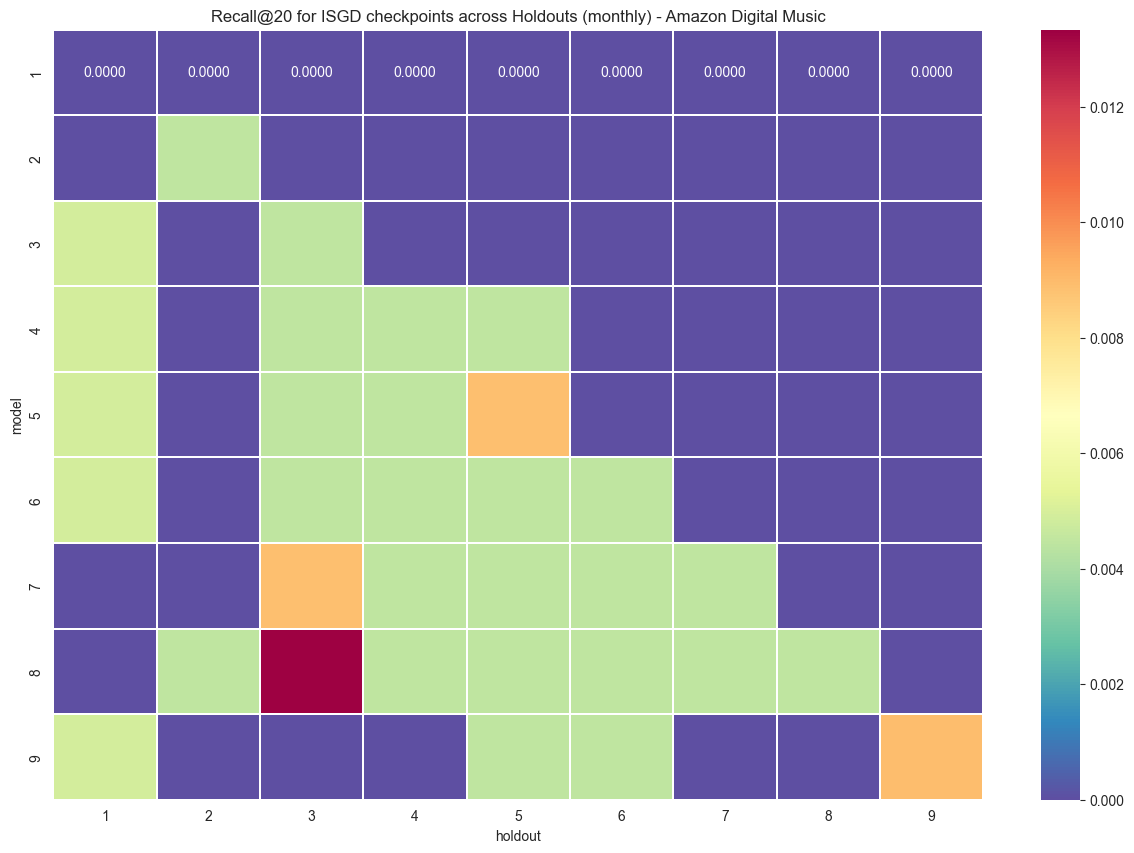

In [9]:
run_evaluate(data = data,
             user_col = namepaths['user_col'],
             item_col = namepaths['item_col'],
             interval_type = namepaths['interval_type'],
             intervals_path = namepaths['intervals_path'],
             use_data_unique_users = namepaths['use_data_unique_users'],
             frequent_users_path = namepaths['frequent_users_path'],
             buckets_path = namepaths['buckets_path'],
             holdouts_path = namepaths['holdouts_path'],
             to_grid_search = namepaths['to_grid_search'],
             num_factors = namepaths['num_factors'],
             num_iter = namepaths['num_iter'],
             learn_rate = namepaths['learn_rate'],
             regularization = namepaths['regularization'],
             random_seed = namepaths['random_seed'],
             results_matrix_path = namepaths['results_matrix_path'],
             recall_heatmap_title = namepaths['recall_heatmap_title'],
             recall_heatmap_path = namepaths['recall_heatmap_path'],
             incrementalTraining_time_record_path = namepaths['incrementalTraining_time_record_path'],
             evaluateHoldouts_time_record_path = namepaths['evaluateHoldouts_time_record_path'])

# run_evaluate(data = data,
#              user_col = user_col,
#              item_col = item_col,
#              interval_type = interval_type,
#              intervals_path = intervals_path, 
#              use_data_unique_users = False,
#              frequent_users_path = frequent_users_path,
#              buckets_path = buckets_path,
#              holdouts_path = holdouts_path,
#              to_grid_search = to_grid_search,
#              random_seed = random_seed,
#              results_matrix_path = results_matrix_path,
#              recall_heatmap_title = recall_heatmap_title,
#              recall_heatmap_path = recall_heatmap_path,
#              incrementalTraining_time_record_path = incrementalTraining_time_record_path,
#              evaluateHoldouts_time_record_path = evaluateHoldouts_time_record_path)

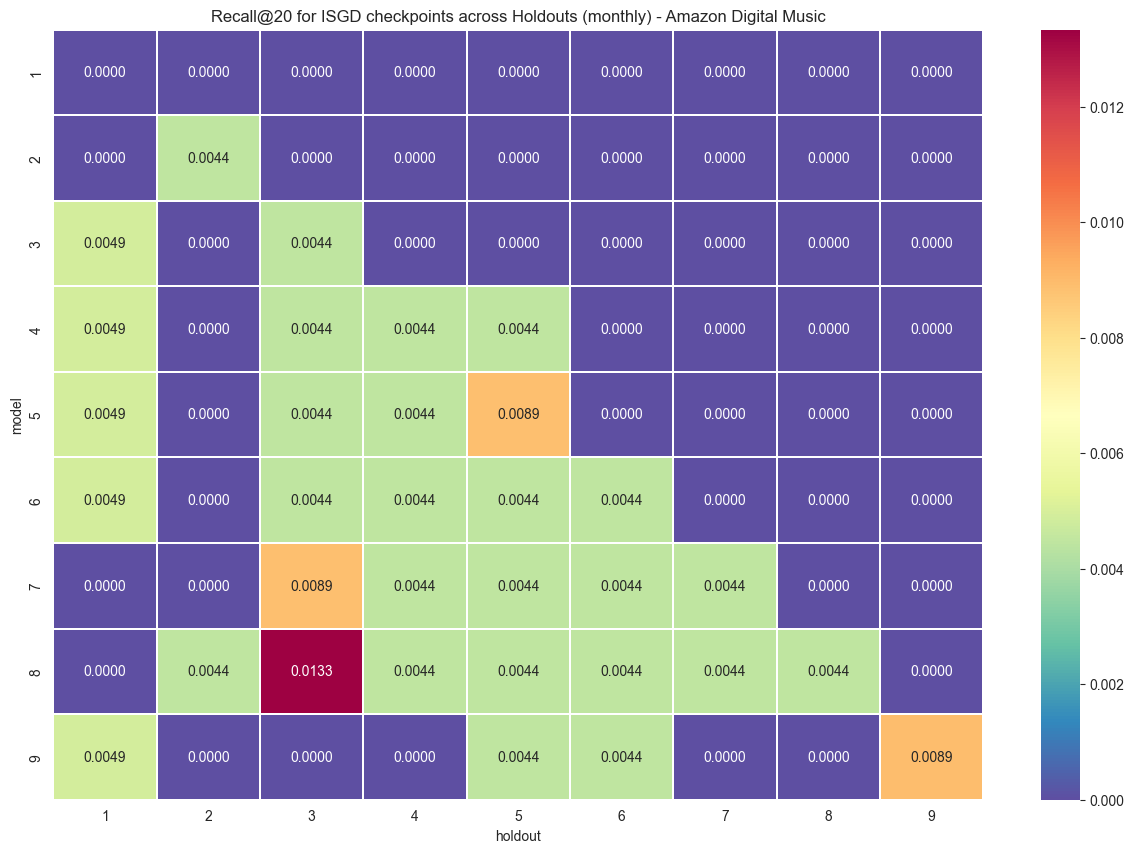

In [12]:
print_heatmap(namepaths['results_matrix_path'], namepaths['recall_heatmap_title'], namepaths['recall_heatmap_path'])

# ADM - monthly buckets - data unique users

In [35]:
namepaths = get_namepaths(sample_year_month = [('2014', '%Y'), ('2014-10', '%Y-%m')],
                          interval_type = 'M',
                          dump_filename ='amazon_digmusic_dump',
                          use_data_unique_users = True,
                          to_grid_search = False,
                          num_factors = 100,
                          num_iter = 6,
                          learn_rate = 0.1,
                          regularization = 0.1,
                          random_seed = 10)
namepaths

{'sample_str': '2014_until_2014-10',
 'dataset_name': 'sample_2014_until_2014-10_amazon_digimusic',
 'user_col': 'user_id',
 'item_col': 'item_id',
 'output_path': 'output/amazon_digmusic_dump/',
 'data_path': 'output/amazon_digmusic_dump/sample_2014_until_2014-10_amazon_digimusic.csv',
 'use_data_unique_users': True,
 'frequent_users_path': 'output/amazon_digmusic_dump/sample_2014_until_2014-10_frequent_users.joblib',
 'to_grid_search': False,
 'random_seed': 10,
 'interval_type': 'M',
 'intervals_path': None,
 'bucket_freq': 'monthly',
 'buckets_path': 'output/amazon_digmusic_dump/sample_2014_until_2014-10_monthly_buckets.joblib',
 'holdouts_path': 'output/amazon_digmusic_dump/sample_2014_until_2014-10_monthly_holdouts.joblib',
 'results_matrix_path': 'output/amazon_digmusic_dump/sample_2014_until_2014-10_amazon_digimusic monthly_bucket ISGD results.csv',
 'recall_heatmap_title': 'Recall@20 for ISGD checkpoints across Holdouts (2014_until_2014-10_monthly) - Amazon Digital Music',
 'r

data.shape (95224, 4)
number of users 19850
number of items 63568
number of duplicated user-item interactions 8902

       user_id         item_id   timestamp        date
0  0006935257  A1KOXZZ2FAVWE0  1388534400  2014-01-01
1  1932192077   A2YIH1J1C1IAN  1388534400  2014-01-01
2  5557585400  A3LEJBI2BBW9S1  1388534400  2014-01-01
3  5558433892   AQCR49SH6TGL4  1388534400  2014-01-01
4  B000031WES   ASRAMMXBYFR6T  1388534400  2014-01-01


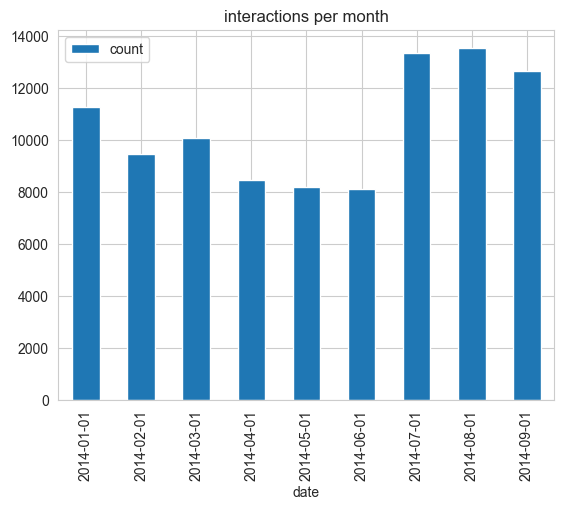

In [36]:
data = load_data_print_info(namepaths['data_path'])


STAGE -> getBucketsHoldouts
Creating buckets. . .
Creating holdouts. . .
Cleaning holdouts. . .
common interactions between holdout 1 and all buckets: 769
common interactions between holdout 2 and all buckets: 660
common interactions between holdout 3 and all buckets: 646
common interactions between holdout 4 and all buckets: 548
common interactions between holdout 5 and all buckets: 527
common interactions between holdout 6 and all buckets: 504
common interactions between holdout 7 and all buckets: 865
common interactions between holdout 8 and all buckets: 817
common interactions between holdout 9 and all buckets: 726
Converting to ImplicitData. . .
Done!

Bucket size, number of users, number of items
 [(9898, 5551, 7273), (7408, 3854, 5515), (7535, 3605, 5564), (5904, 2912, 4515), (5358, 2631, 4076), (5199, 2562, 4021), (8823, 3863, 5959), (8591, 3752, 5851), (7932, 3100, 5496)]
Holdouts size, number of users, number of items
 [(1399, 1399, 1300), (2061, 2061, 1882), (2555, 2555, 23

(         0         1         2         3         4         5         6  \
 0  0.00143  0.000000  0.000000  0.000749  0.000000  0.000000  0.000593   
 1  0.00000  0.001941  0.000000  0.000541  0.000000  0.000000  0.000000   
 2  0.00000  0.000970  0.001174  0.000431  0.000000  0.000000  0.000000   
 3  0.00000  0.000970  0.001174  0.001164  0.000000  0.000000  0.000000   
 4  0.00000  0.000485  0.000783  0.001164  0.000354  0.000000  0.000000   
 5  0.00000  0.000485  0.000391  0.001164  0.000707  0.000344  0.000000   
 6  0.00000  0.000485  0.000000  0.001164  0.001061  0.000688  0.001102   
 7  0.00000  0.000485  0.000391  0.001164  0.000707  0.000688  0.000881   
 8  0.00000  0.000485  0.000391  0.000776  0.000354  0.000344  0.000661   
 
           7         8  
 0  0.000000  0.000000  
 1  0.000000  0.000000  
 2  0.000000  0.000000  
 3  0.000000  0.000000  
 4  0.000000  0.000000  
 5  0.000000  0.000000  
 6  0.000000  0.000000  
 7  0.000603  0.000223  
 8  0.001004  0.001478 

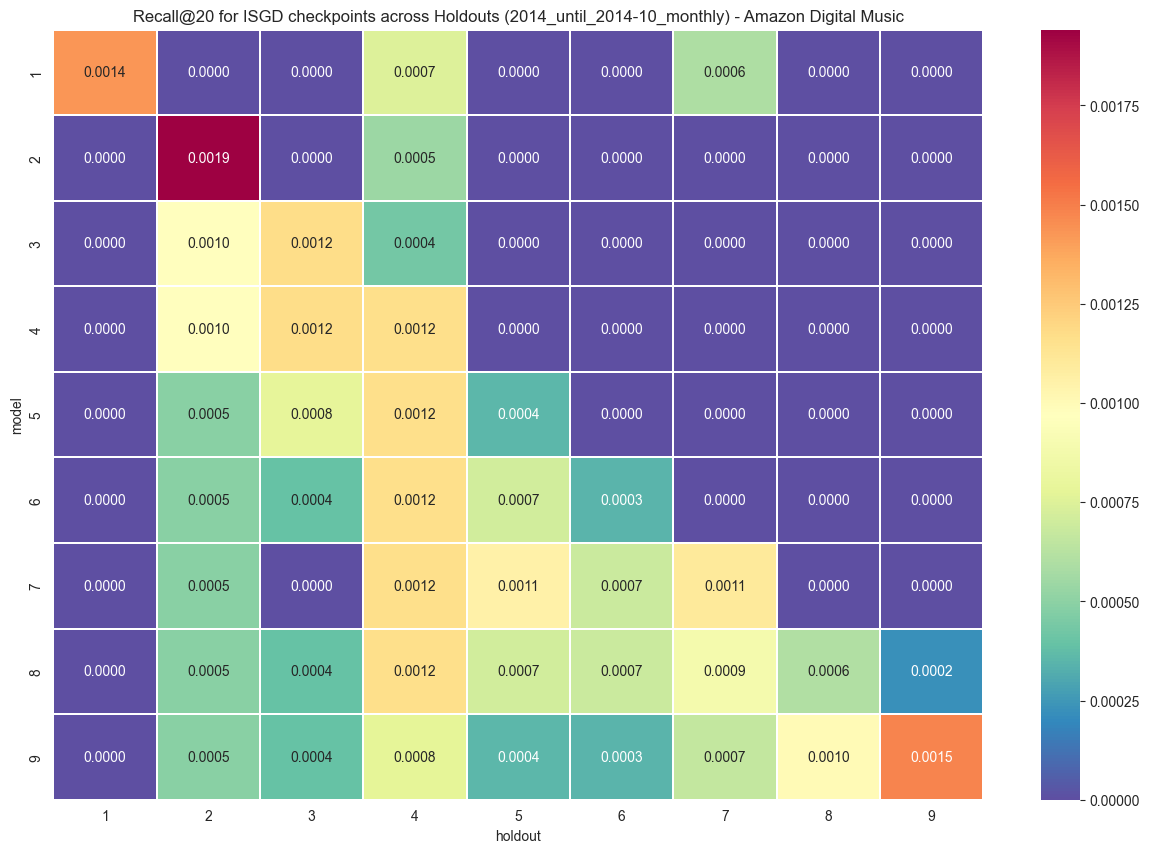

In [37]:
run_evaluate(data = data,
             user_col = namepaths['user_col'],
             item_col = namepaths['item_col'],
             interval_type = namepaths['interval_type'],
             intervals_path = namepaths['intervals_path'],
             use_data_unique_users = namepaths['use_data_unique_users'],
             frequent_users_path = namepaths['frequent_users_path'],
             buckets_path = namepaths['buckets_path'],
             holdouts_path = namepaths['holdouts_path'],
             to_grid_search = namepaths['to_grid_search'],
             num_factors = namepaths['num_factors'],
             num_iter = namepaths['num_iter'],
             learn_rate = namepaths['learn_rate'],
             regularization = namepaths['regularization'],
             random_seed = namepaths['random_seed'],
             results_matrix_path = namepaths['results_matrix_path'],
             recall_heatmap_title = namepaths['recall_heatmap_title'],
             recall_heatmap_path = namepaths['recall_heatmap_path'],
             incrementalTraining_time_record_path = namepaths['incrementalTraining_time_record_path'],
             evaluateHoldouts_time_record_path = namepaths['evaluateHoldouts_time_record_path'])

# ADM - quarterly buckets

In [ ]:
namepaths = get_namepaths(sample_year_month = [('2014', '%Y'), ('2014-4', '%Y-%m')],
                          interval_type = 'Q',
                          dump_filename ='amazon_digmusic_dump',
                          use_data_unique_users = False,
                          to_grid_search = False,
                          num_factors = 100,
                          num_iter = 6,
                          learn_rate = 0.1,
                          regularization = 0.1,
                          random_seed = 10)

data = load_data_print_info(namepaths['data_path'])


STAGE -> getBucketsHoldouts
Creating buckets. . .
Creating holdouts. . .
Cleaning holdouts. . .
common interactions between holdout 1 and all buckets: 652
common interactions between holdout 2 and all buckets: 629
common interactions between holdout 3 and all buckets: 589
Converting to ImplicitData. . .
Done!

Bucket size, number of users, number of items
 [(29000, 10869, 20990), (21712, 8391, 16291), (36603, 12331, 24212)]
Holdouts size, number of users, number of items
 [(1865, 1865, 1738), (3002, 3002, 2731), (3042, 3042, 2594)]


STAGE -> to_grid_search
num_factors, num_iter, learn_rate, regularization
 (100, 6, 0.1, 0.1)


STAGE -> ISGD model


STAGE -> EvaluateHoldouts
----------------------------------------------------------------------------------------------------
Train bucket 0
Test Holdout 0
Test Holdout 1
Test Holdout 2
----------------------------------------------------------------------------------------------------
Train bucket 1
Test Holdout 0
Test Holdout 1
Test Hol

(          0         1         2
 0  0.000000  0.000666  0.000329
 1  0.001072  0.001666  0.000329
 2  0.001072  0.001332  0.003945,
 0.0018701098237817349,
 ([0.0010723860589812334, 0.00036963739991033686], 0.0007210117294457852),
 (0.000603886952933969,
  [0.0010723860589812334, 0.0010723860589812334, -0.00033311125916055963]),
 0.0004412282380816179)

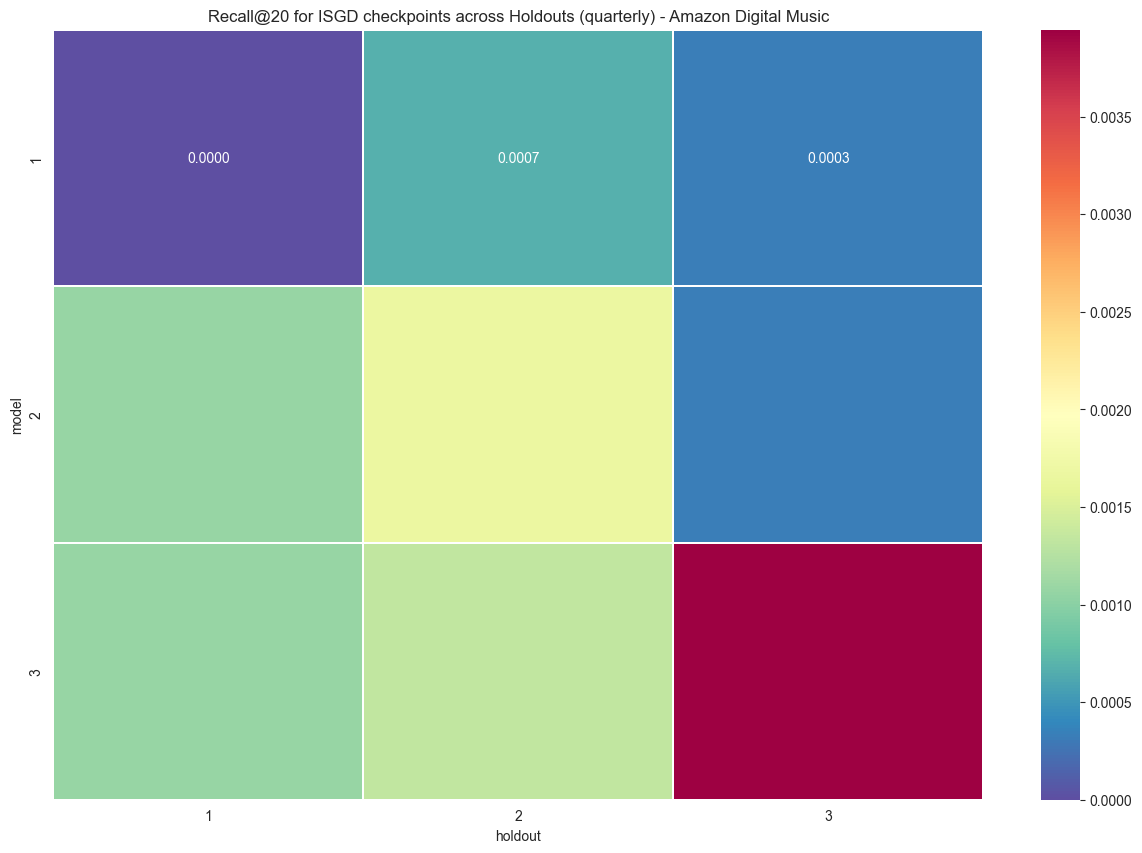

In [7]:
run_evaluate(data = data,
             user_col = namepaths['user_col'],
             item_col = namepaths['item_col'],
             interval_type = namepaths['interval_type'],
             intervals_path = namepaths['intervals_path'],
             use_data_unique_users = namepaths['use_data_unique_users'],
             frequent_users_path = namepaths['frequent_users_path'],
             buckets_path = namepaths['buckets_path'],
             holdouts_path = namepaths['holdouts_path'],
             to_grid_search = namepaths['to_grid_search'],
             num_factors = namepaths['num_factors'],
             num_iter = namepaths['num_iter'],
             learn_rate = namepaths['learn_rate'],
             regularization = namepaths['regularization'],
             random_seed = namepaths['random_seed'],
             results_matrix_path = namepaths['results_matrix_path'],
             recall_heatmap_title = namepaths['recall_heatmap_title'],
             recall_heatmap_path = namepaths['recall_heatmap_path'],
             incrementalTraining_time_record_path = namepaths['incrementalTraining_time_record_path'],
             evaluateHoldouts_time_record_path = namepaths['evaluateHoldouts_time_record_path'])

# run_evaluate(data = data,
#              user_col = user_col,
#              item_col = item_col,
#              interval_type = interval_type,
#              intervals_path = intervals_path, 
#              use_data_unique_users = False,
#              frequent_users_path = frequent_users_path,
#              buckets_path = buckets_path,
#              holdouts_path = holdouts_path,
#              to_grid_search = to_grid_search,
#              random_seed = random_seed,
#              results_matrix_path = results_matrix_path,
#              recall_heatmap_title = recall_heatmap_title,
#              recall_heatmap_path = recall_heatmap_path,
#              incrementalTraining_time_record_path = incrementalTraining_time_record_path,
#              evaluateHoldouts_time_record_path = evaluateHoldouts_time_record_path)


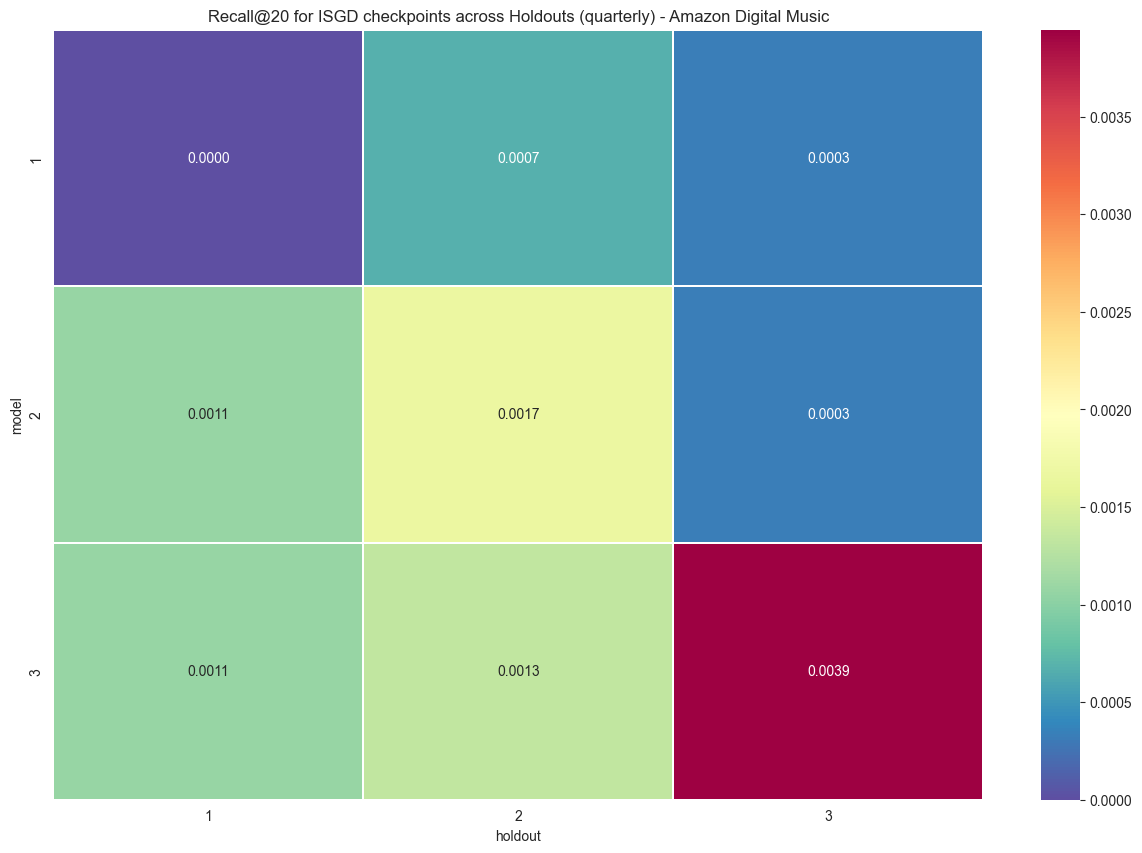

In [14]:
print_heatmap(namepaths['results_matrix_path'], namepaths['recall_heatmap_title'], namepaths['recall_heatmap_path'])

# ADM - semesterly buckets

In [15]:
namepaths = get_namepaths(sample_year_month = [('2014', '%Y'), ('2014-4', '%Y-%m')],
                          interval_type = 'S',
                          dump_filename ='amazon_digmusic_dump',
                          use_data_unique_users = False,
                          to_grid_search = False,
                          num_factors = 100,
                          num_iter = 6,
                          learn_rate = 0.1,
                          regularization = 0.1,
                          random_seed = 10)

data = load_data_print_info(namepaths['data_path'])


STAGE -> getBucketsHoldouts
Creating buckets. . .
Creating holdouts. . .
Cleaning holdouts. . .
common interactions between holdout 1 and all buckets: 1295
common interactions between holdout 2 and all buckets: 1162
Converting to ImplicitData. . .
Done!

Bucket size, number of users, number of items
 [(50872, 15446, 36394), (31758, 9426, 21247)]
Holdouts size, number of users, number of items
 [(4707, 4707, 4267), (7887, 7887, 6351)]


STAGE -> to_grid_search
num_factors, num_iter, learn_rate, regularization
 (100, 6, 0.1, 0.1)


STAGE -> ISGD model


STAGE -> EvaluateHoldouts
----------------------------------------------------------------------------------------------------
Train bucket 0
Test Holdout 0
Test Holdout 1
----------------------------------------------------------------------------------------------------
Train bucket 1
Test Holdout 0
Test Holdout 1
          0         1
0  0.001700  0.000000
1  0.001275  0.001902


stage -> metrics
avg recall 0.001801
BWT (v. Lopez-Paz 

(          0         1
 0  0.001700  0.000000
 1  0.001275  0.001902,
 0.0018007300862089375,
 ([-0.0004248990864669641], -0.0004248990864669641),
 (-0.0004248990864669641, [-0.0004248990864669641]),
 0.0)

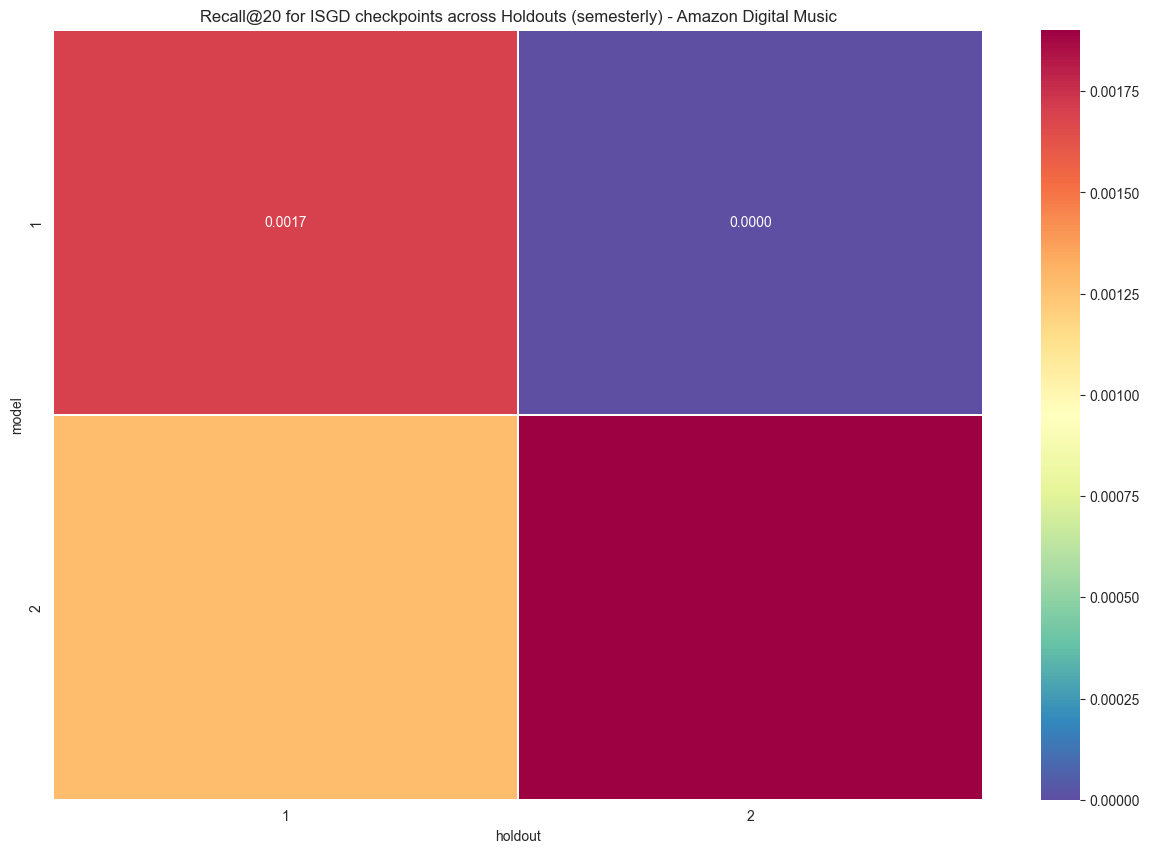

In [8]:
run_evaluate(data = data,
             user_col = namepaths['user_col'],
             item_col = namepaths['item_col'],
             interval_type = namepaths['interval_type'],
             intervals_path = namepaths['intervals_path'],
             use_data_unique_users = namepaths['use_data_unique_users'],
             frequent_users_path = namepaths['frequent_users_path'],
             buckets_path = namepaths['buckets_path'],
             holdouts_path = namepaths['holdouts_path'],
             to_grid_search = namepaths['to_grid_search'],
             num_factors = namepaths['num_factors'],
             num_iter = namepaths['num_iter'],
             learn_rate = namepaths['learn_rate'],
             regularization = namepaths['regularization'],
             random_seed = namepaths['random_seed'],
             results_matrix_path = namepaths['results_matrix_path'],
             recall_heatmap_title = namepaths['recall_heatmap_title'],
             recall_heatmap_path = namepaths['recall_heatmap_path'],
             incrementalTraining_time_record_path = namepaths['incrementalTraining_time_record_path'],
             evaluateHoldouts_time_record_path = namepaths['evaluateHoldouts_time_record_path'])

# run_evaluate(data = data,
#              user_col = user_col,
#              item_col = item_col,
#              interval_type = interval_type,
#              intervals_path = intervals_path, 
#              use_data_unique_users = False,
#              frequent_users_path = frequent_users_path,
#              buckets_path = buckets_path,
#              holdouts_path = holdouts_path,
#              to_grid_search = to_grid_search,
#              random_seed = random_seed,
#              results_matrix_path = results_matrix_path,
#              recall_heatmap_title = recall_heatmap_title,
#              recall_heatmap_path = recall_heatmap_path,
#              incrementalTraining_time_record_path = incrementalTraining_time_record_path,
#              evaluateHoldouts_time_record_path = evaluateHoldouts_time_record_path)

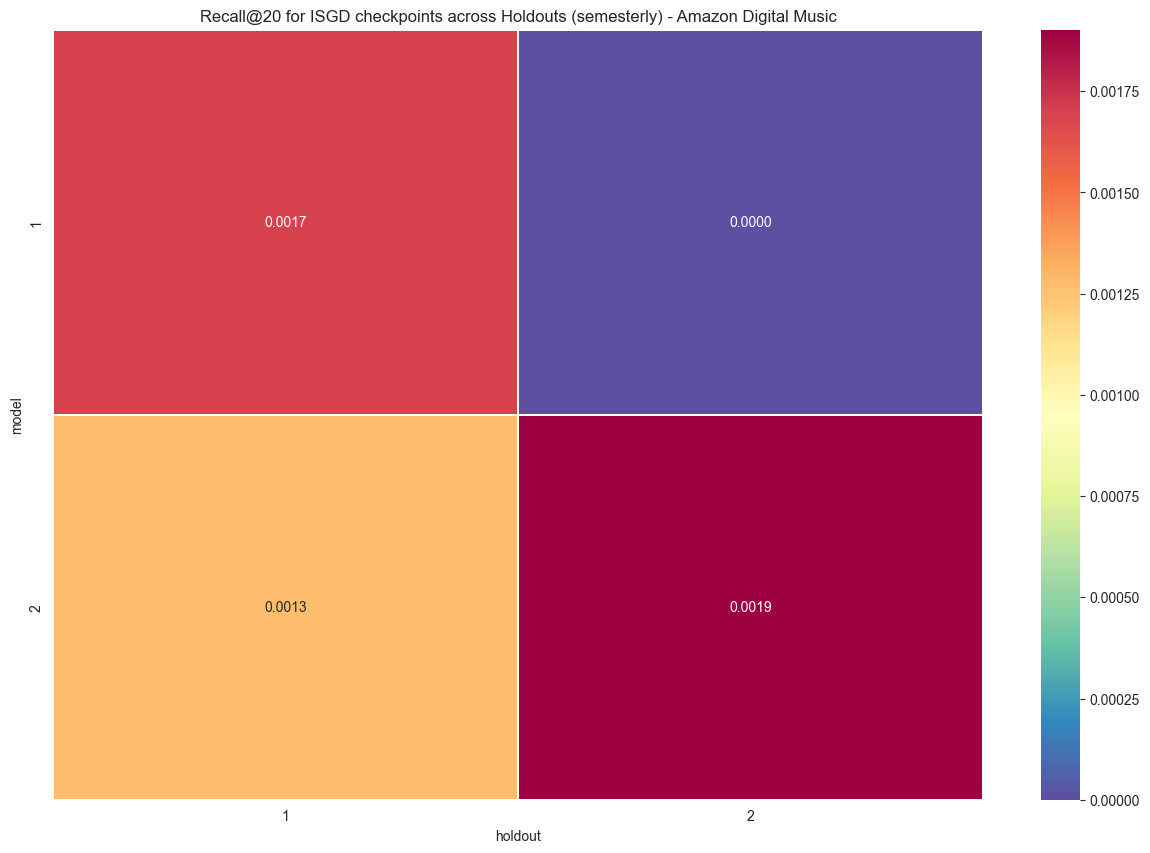

In [16]:
print_heatmap(namepaths['results_matrix_path'], namepaths['recall_heatmap_title'], namepaths['recall_heatmap_path'])

# Thesis experiment - with manually set parameters

In [40]:
namepaths = get_namepaths(sample_year_month = [('2014', '%Y'), ('2014-4', '%Y-%m')],
                          interval_type = 'M',
                          dump_filename ='amazon_digmusic_dump',
                          use_data_unique_users=True,
                          to_grid_search = False,
                          num_factors = 100,
                          num_iter = 6,
                          learn_rate = 0.1,
                          regularization = 0.1,
                          random_seed = 10)
namepaths

{'sample_str': '2014_until_2014-4',
 'dataset_name': 'sample_2014_until_2014-4_amazon_digimusic',
 'user_col': 'user_id',
 'item_col': 'item_id',
 'output_path': 'output/amazon_digmusic_dump/',
 'data_path': 'output/amazon_digmusic_dump/sample_2014_until_2014-4_amazon_digimusic.csv',
 'use_data_unique_users': True,
 'frequent_users_path': 'output/amazon_digmusic_dump/sample_2014_until_2014-4_frequent_users.joblib',
 'to_grid_search': False,
 'num_factors': 100,
 'num_iter': 6,
 'learn_rate': 0.1,
 'regularization': 0.1,
 'random_seed': 10,
 'interval_type': 'M',
 'intervals_path': None,
 'bucket_freq': 'monthly',
 'buckets_path': 'output/amazon_digmusic_dump/sample_2014_until_2014-4_monthly_buckets.joblib',
 'holdouts_path': 'output/amazon_digmusic_dump/sample_2014_until_2014-4_monthly_holdouts.joblib',
 'results_matrix_path': 'output/amazon_digmusic_dump/sample_2014_until_2014-4_amazon_digimusic monthly_bucket ISGD results.csv',
 'recall_heatmap_title': 'Recall@20 for ISGD checkpoints

data.shape (29781, 4)
number of users 9991
number of items 21622
number of duplicated user-item interactions 2974

       user_id         item_id   timestamp        date
0  0006935257  A1KOXZZ2FAVWE0  1388534400  2014-01-01
1  1932192077   A2YIH1J1C1IAN  1388534400  2014-01-01
2  5557585400  A3LEJBI2BBW9S1  1388534400  2014-01-01
3  5558433892   AQCR49SH6TGL4  1388534400  2014-01-01
4  B00008GSAW  A1TCDA1FGUUKX5  1388534400  2014-01-01


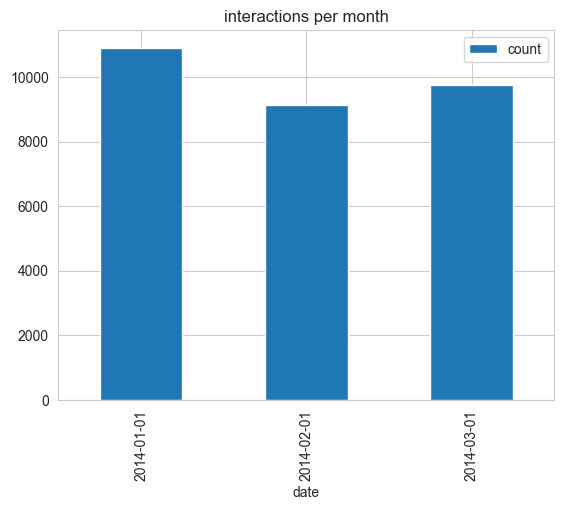

In [41]:
data = load_data_print_info(namepaths['data_path'])


STAGE -> getBucketsHoldouts
Creating buckets. . .
Creating holdouts. . .
Cleaning holdouts. . .
common interactions between holdout 1 and all buckets: 731
common interactions between holdout 2 and all buckets: 635
common interactions between holdout 3 and all buckets: 627
Converting to ImplicitData. . .
Done!

Bucket size, number of users, number of items
 [(9516, 5215, 7016), (7120, 3587, 5347), (7227, 3319, 5350)]
Holdouts size, number of users, number of items
 [(1397, 1397, 1293), (1998, 1998, 1828), (2523, 2523, 2302)]


STAGE -> to_grid_search
num_factors, num_iter, learn_rate, regularization
 (100, 6, 0.1, 0.1)


STAGE -> ISGD model


STAGE -> EvaluateHoldouts
----------------------------------------------------------------------------------------------------
Train bucket 0
Test Holdout 0
Test Holdout 1
recommendations not made for users in holdout 1 x checkpoint 0: 414
Test Holdout 2
recommendations not made for users in holdout 2 x checkpoint 0: 966
--------------------------

(          0         1         2
 0  0.000716  0.000000  0.000000
 1  0.000716  0.000501  0.000000
 2  0.000000  0.000501  0.000793,
 0.0006696757362288024,
 ([0.0, -0.00035790980672870435], -0.00017895490336435218),
 (-0.00023860653781913624, [0.0, -0.0007158196134574087, 0.0]),
 0.0)

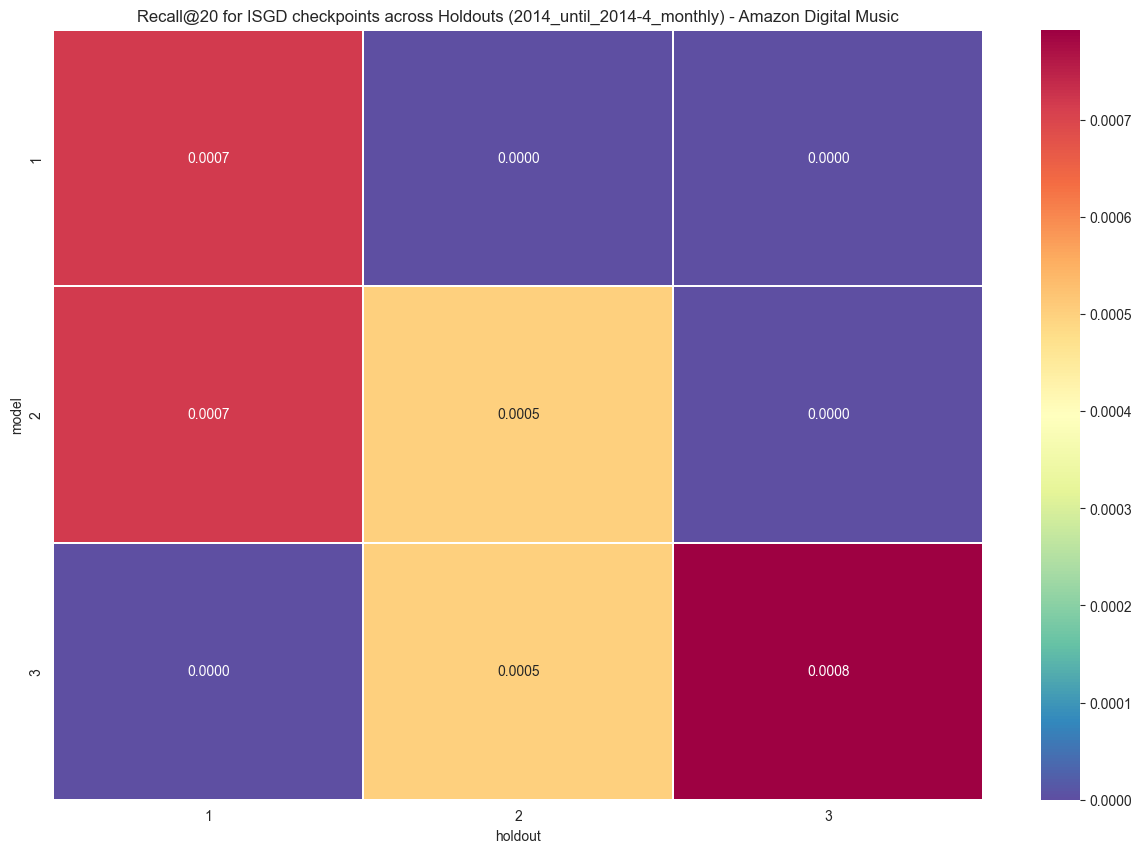

In [42]:
run_evaluate(data = data,
             user_col = namepaths['user_col'],
             item_col = namepaths['item_col'],
             interval_type = namepaths['interval_type'],
             intervals_path = namepaths['intervals_path'],
             use_data_unique_users = namepaths['use_data_unique_users'],
             frequent_users_path = namepaths['frequent_users_path'],
             buckets_path = namepaths['buckets_path'],
             holdouts_path = namepaths['holdouts_path'],
             to_grid_search = namepaths['to_grid_search'],
             num_factors = namepaths['num_factors'],
             num_iter = namepaths['num_iter'],
             learn_rate = namepaths['learn_rate'],
             regularization = namepaths['regularization'],
             random_seed = namepaths['random_seed'],
             results_matrix_path = namepaths['results_matrix_path'],
             recall_heatmap_title = namepaths['recall_heatmap_title'],
             recall_heatmap_path = namepaths['recall_heatmap_path'],
             incrementalTraining_time_record_path = namepaths['incrementalTraining_time_record_path'],
             evaluateHoldouts_time_record_path = namepaths['evaluateHoldouts_time_record_path'])

data.shape (29781, 4)
number of users 9991
number of items 21622
number of duplicated user-item interactions 2974

       user_id         item_id   timestamp        date
0  0006935257  A1KOXZZ2FAVWE0  1388534400  2014-01-01
1  1932192077   A2YIH1J1C1IAN  1388534400  2014-01-01
2  5557585400  A3LEJBI2BBW9S1  1388534400  2014-01-01
3  5558433892   AQCR49SH6TGL4  1388534400  2014-01-01
4  B00008GSAW  A1TCDA1FGUUKX5  1388534400  2014-01-01


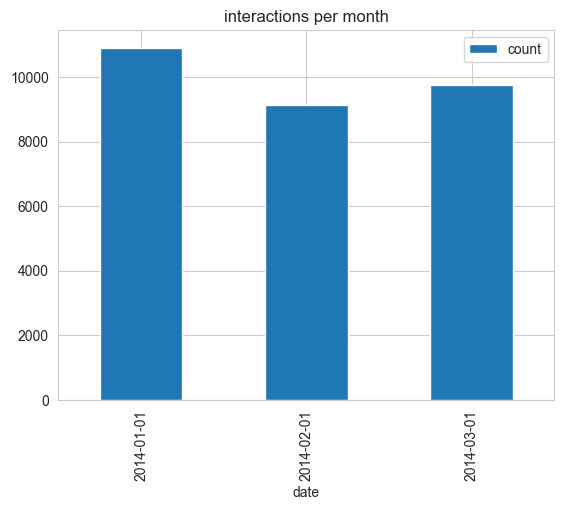

In [43]:
namepaths = get_namepaths(sample_year_month = [('2014', '%Y'), ('2014-4', '%Y-%m')],
                          interval_type = 'M',
                          dump_filename ='amazon_digmusic_dump',
                          use_data_unique_users=False,
                          to_grid_search = False,
                          num_factors = 100,
                          num_iter = 6,
                          learn_rate = 0.1,
                          regularization = 0.1,
                          random_seed = 10)

data = load_data_print_info(namepaths['data_path'])

In [44]:
run_evaluate(data = data,
             user_col = namepaths['user_col'],
             item_col = namepaths['item_col'],
             interval_type = namepaths['interval_type'],
             intervals_path = namepaths['intervals_path'],
             use_data_unique_users = namepaths['use_data_unique_users'],
             frequent_users_path = namepaths['frequent_users_path'],
             buckets_path = namepaths['buckets_path'],
             holdouts_path = namepaths['holdouts_path'],
             to_grid_search = namepaths['to_grid_search'],
             num_factors = namepaths['num_factors'],
             num_iter = namepaths['num_iter'],
             learn_rate = namepaths['learn_rate'],
             regularization = namepaths['regularization'],
             random_seed = namepaths['random_seed'],
             results_matrix_path = namepaths['results_matrix_path'],
             recall_heatmap_title = namepaths['recall_heatmap_title'],
             recall_heatmap_path = namepaths['recall_heatmap_path'],
             incrementalTraining_time_record_path = namepaths['incrementalTraining_time_record_path'],
             evaluateHoldouts_time_record_path = namepaths['evaluateHoldouts_time_record_path'])


STAGE -> getBucketsHoldouts
Creating buckets. . .
Creating holdouts. . .
Cleaning holdouts. . .
common interactions between holdout 1 and all buckets: 0
common interactions between holdout 2 and all buckets: 0
common interactions between holdout 3 and all buckets: 0
Converting to ImplicitData. . .
Done!

Bucket size, number of users, number of items
 [(10913, 5215, 8080), (9118, 4505, 6872), (9750, 4709, 7264)]
Holdouts size, number of users, number of items
 [(0, 0, 0), (0, 0, 0), (0, 0, 0)]


STAGE -> to_grid_search
num_factors, num_iter, learn_rate, regularization
 (100, 6, 0.1, 0.1)


STAGE -> ISGD model


STAGE -> EvaluateHoldouts
----------------------------------------------------------------------------------------------------
Train bucket 0
Test Holdout 0


ZeroDivisionError: division by zero

___
# from now on is the original code

# Amazon Digital Music
Small subset, ratings only.  
https://nijianmo.github.io/amazon/index.html


In [4]:
data = pd.read_csv('output/amazon_digmusic_dump/sampled_amazon_digmusic.csv')
dataset_name = 'Amazon_digital_music'
user_col = 'user_id'
item_col = 'item_id'

In [5]:
data.shape, data.user_id.nunique(), data.item_id.nunique()

((95224, 4), 19850, 63598)

In [6]:
data[['user_id', 'item_id']].duplicated().sum()

8886

In [7]:
data.head()

,user_id,item_id,timestamp,date
0,0006935257,A1KOXZZ2FAVWE0,1388534400,2014-01-01
1,1932192077,A2YIH1J1C1IAN,1388534400,2014-01-01
2,5557585400,A3LEJBI2BBW9S1,1388534400,2014-01-01
3,5558433892,AQCR49SH6TGL4,1388534400,2014-01-01
4,B000031WES,ASRAMMXBYFR6T,1388534400,2014-01-01


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95224 entries, 0 to 95223
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_id    95224 non-null  object
 1   item_id    95224 non-null  object
 2   timestamp  95224 non-null  int64 
 3   date       95224 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.9+ MB


### Convert timestamp

In [9]:
%%time 
# 2.42s
data['date'] = data['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
# data.sort_values(by='timestamp', inplace=True)

CPU times: total: 594 ms
Wall time: 928 ms


In [10]:
data.head()

,user_id,item_id,timestamp,date
0,0006935257,A1KOXZZ2FAVWE0,1388534400,2014-01-01
1,1932192077,A2YIH1J1C1IAN,1388534400,2014-01-01
2,5557585400,A3LEJBI2BBW9S1,1388534400,2014-01-01
3,5558433892,AQCR49SH6TGL4,1388534400,2014-01-01
4,B000031WES,ASRAMMXBYFR6T,1388534400,2014-01-01


CPU times: total: 15.6 ms
Wall time: 102 ms


Text(0.5, 1.0, 'interactions per month')

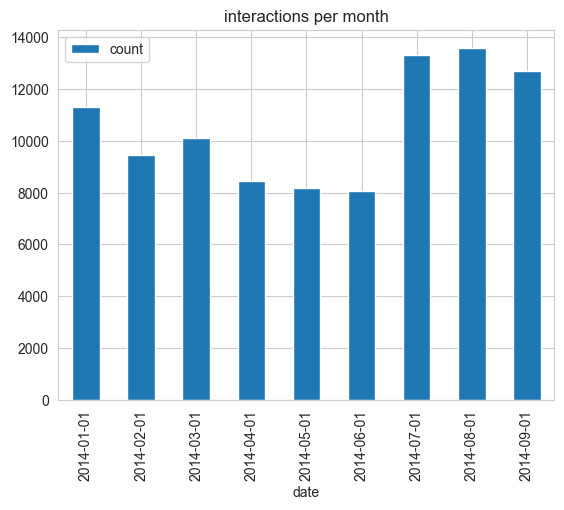

In [11]:
%%time
# 198ms
interactions_per_month = data.groupby(by=['date']).count().iloc[:, 0]
interactions_per_month.name = 'count'
interactions_per_month=interactions_per_month.reset_index()
_ = interactions_per_month.copy()
_['date'] = _['date'].dt.date
_.groupby('date').sum().plot(kind='bar')
plt.title('interactions per month');

___
## Get intervals and Frequent users (threshold = 0.75)

time intervals

In [12]:
user_presence_df = pd.read_csv('output/amazon_digmusic_dump/sample_user_presence_df.csv')
user_month_interactions = pd.read_csv('output/amazon_digmusic_dump/sample_user_month_interactions.csv')

___
## Experiments using Quarter/Semester

In [13]:
data.shape

(95224, 4)

In [17]:
trimestres = joblib.load('output/amazon_digmusic_dump/sample_trimestres.joblib')
semestres = joblib.load('output/amazon_digmusic_dump/sample_semestres.joblib')
frequent_users = joblib.load('output/amazon_digmusic_dump/sample_frequent_users.joblib')

In [22]:
%%time
# 3min 38s
buckets, holdouts = getBucketsHoldouts(
    data=data,# data[ data['date'].dt.month==1 ],#
    user_col=user_col,
    item_col=item_col,
    frequent_users=frequent_users[1],#data['user_id'].unique(),
    interval_type='QS',
    intervals=trimestres, 
    cold_start_buckets=0)

Creating buckets. . .
Creating holdouts. . .
Cleaning holdouts. . .
common interactions between holdout 1 and all buckets: 652
common interactions between holdout 2 and all buckets: 629
common interactions between holdout 3 and all buckets: 589
Converting to ImplicitData. . .
Done!
CPU times: total: 23 s
Wall time: 31.7 s


In [23]:
sum( [b.size for b in buckets] ) + sum( [h.size for h in holdouts] )

95224

In [24]:
joblib.dump(buckets, 'output/amazon_digmusic_dump/sample_buckets.joblib')
joblib.dump(holdouts, 'output/amazon_digmusic_dump/sample_holdouts.joblib')

['output/amazon_digmusic_dump/sample_holdouts.joblib']

In [25]:
buckets = joblib.load('output/amazon_digmusic_dump/sample_buckets.joblib')
holdouts = joblib.load('output/amazon_digmusic_dump/sample_holdouts.joblib')

In [27]:
[(b.size, len(b.userset), len(b.itemset)) for b in buckets]

[(29000, 10869, 20990), (21712, 8391, 16291), (36603, 12331, 24212)]

In [28]:
[(b.size, len(b.userset), len(b.itemset)) for b in holdouts]

[(1865, 1865, 1738), (3002, 3002, 2731), (3042, 3042, 2594)]

### ISGD

Hyperparameters

In [29]:
GRID_SEARCH = False

In [30]:
%%time
import itertools
def grid_search(model, stream, random_seed = 10, interleaved=10):    
    num_factors = [50, 100, 150, 200]
    num_iter = [1, 2, 5, 8]
    learn_rate = [0.01, 0.05, 0.1, 0.25, 0.5]
    regularization = [0.01, 0.05, 0.1, 0.25, 0.5]
    num_nodes = [1, 2, 4, 8, 16]
    grid = [num_factors, num_iter, learn_rate, regularization, num_nodes]
    grid = list(itertools.product(*grid))
    results = []
    for i, hp in enumerate(grid):
        print(((i*100)/len(grid)), '%')
        empty_stream = ImplicitData([], [])
        nf, ni, lr, reg, nn = hp
        m = model(empty_stream, nf, ni, lr, reg, reg, random_seed)
        e = EvalPrequential(m, stream, metrics = ["Recall@N"])
        result = e.Evaluate(start_eval=0, count=stream.size, interleaved=interleaved)
        results.append( np.mean(result['Recall@N']) )
    return grid, results    

# OPTIONAL FOR NOW
if GRID_SEARCH:
    prop = 0.05 # 0.1 #
    hp_sample = data.iloc[:round( data.shape[0]*prop )]
    stream = ImplicitData(hp_sample[user_col], hp_sample[item_col]) #(data['playlist_id'],data['track_id'])    
    grid, results = grid_search(model=ISGD, stream=stream, random_seed=10, interleaved=100 )
    len(grid), len(results), max(results) # (243, 243, 0.0026656511805026656)
    print(  grid[ np.argmax( results ) ] )

CPU times: total: 0 ns
Wall time: 0 ns


In [31]:
if GRID_SEARCH:
    num_factors, num_iter, learn_rate, regularization, num_nodes = grid[ np.argmax( results ) ]
else:
    num_factors = 100
    num_iter = 6
    learn_rate = 0.1
    regularization = 0.1
    num_nodes = None

# previous  (100, 5, 0.5, 0.3, 4)

# OLD
# define hyperparameters (SAME AS LASTFM) ????
# num_factors = 160
# num_iter = 4
# learn_rate = 0.5
# regularization = 0.4
# num_nodes = 8

In [32]:
# transforma interações em objeto que contem mappings usuário-itens e item-usuários, contém também métodos de suporte. recebe listas
# stream = ImplicitData(data[user_col], data[item_col])
# O modelo deve ser iniciado com uma lista vazia
empty_stream = ImplicitData([], [])
# Se o stream for passado, ao excluir itens conhecidos o recall é sempre 0. Ao permitir a recomendação de itens já vistos, o recall não é 0.
model = ISGD(empty_stream, 
             num_factors, 
             num_iter, 
             learn_rate = learn_rate,
             u_regularization = regularization,
             i_regularization = regularization,
             random_seed = 10)

In [33]:
# criamos instancia de EvaluateHoldouts para treinar o modelo e criar checkpoints
eval = EvaluateHoldouts(model=model, buckets=buckets, holdouts=holdouts)

In [34]:
%%time
# 1h 27min 10s
eval.Train_Evaluate(N_recommendations=20, exclude_known_items=True, default_user='none')

----------------------------------------------------------------------------------------------------
Train bucket 0
Test Holdout 0
Test Holdout 1
Test Holdout 2
----------------------------------------------------------------------------------------------------
Train bucket 1
Test Holdout 0
Test Holdout 1
Test Holdout 2
----------------------------------------------------------------------------------------------------
Train bucket 2
Test Holdout 0
Test Holdout 1
Test Holdout 2
CPU times: total: 38min 36s
Wall time: 52min 8s


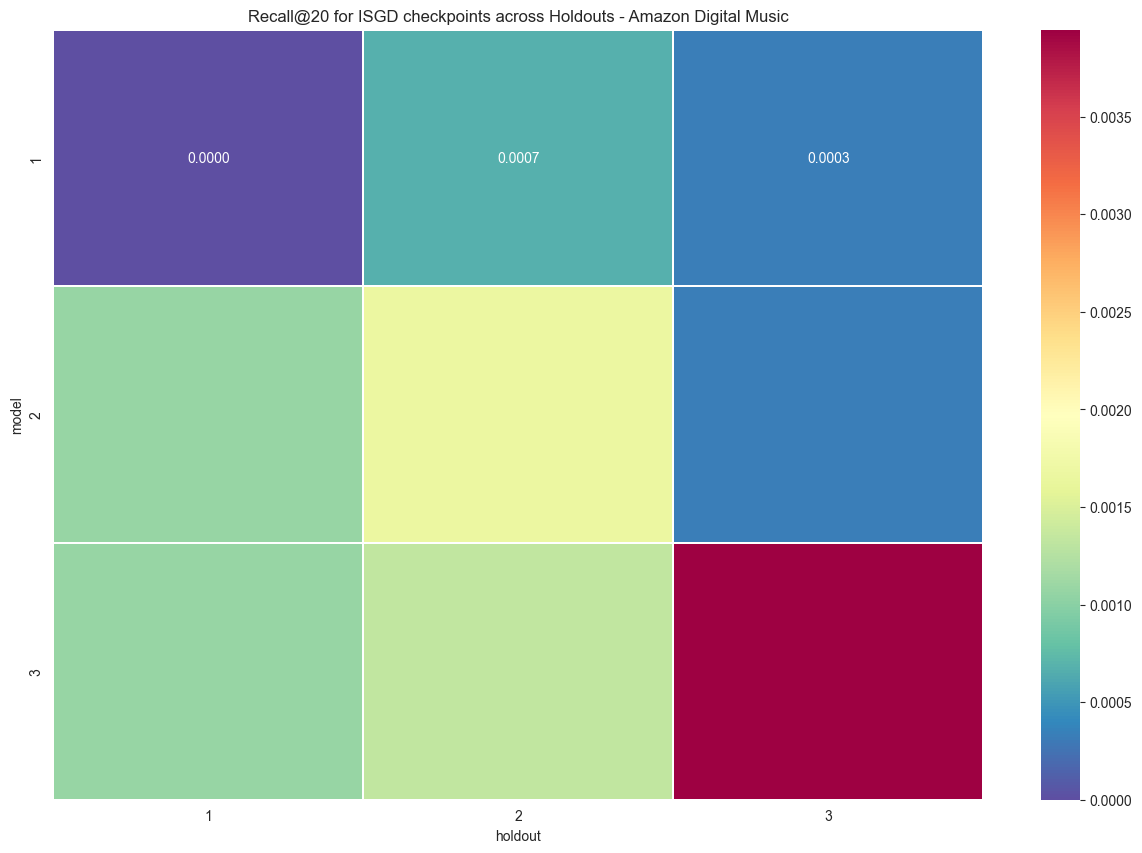

In [35]:
rm = eval.results_matrix
df = pd.DataFrame(rm)
df.to_csv('output/amazon_digmusic_dump/sample_amazon_digital_music quarterly_bucket ISGD results.csv', index=False)

recall_heatmap(df,
    round_point=4,
    title='Recall@20 for ISGD checkpoints across Holdouts - Amazon Digital Music',
    filepath='images/heatmaps/amazon_digmusic_dump/sample_amazon_digital_music quarterly_bucket ISGD heatmap.png') 

In [36]:
arecall = avg_recall(df)
arecall

0.0018701098237817349

In [37]:
BWT, meanBWT = compute_BWT(df)
BWT, meanBWT

([0.0010723860589812334, 0.00036963739991033686], 0.0007210117294457852)

In [38]:
FWT = compute_FWT(df)
FWT
# que itens que usuario utilizou no passado e deixou de consumir o sistema ainda pode recomendar

0.0004412282380816179

In [39]:
joblib.dump(eval.IncrementalTraining_time_record, 'output/amazon_digmusic_dump/sample_amazon_digmusic quarterly_bucket ISGD training time.joblib')
joblib.dump(eval.EvaluateHoldouts_time_record, 'output/amazon_digmusic_dump/sample_amazon_digmusic quarterly_bucket ISGD eval time.joblib')

['output/amazon_digmusic_dump/sample_amazon_digmusic quarterly_bucket ISGD eval time.joblib']

In [40]:
import pandas as pd
import numpy as np

def avg_recall(results_matrix):
    return np.mean( np.diag(results_matrix) )

def compute_BWT(results_matrix): # Díaz-Rodriguez et al. 2018
    diff = []
    n_checkpoints = results_matrix.shape[0]
    for i in range(1, n_checkpoints): # 1 means holdout 2, 2 means 3, so on
        for j in range(i):
            Rij = results_matrix.iloc[i,j] # get models performances' on previous holdouts
            Rjj = results_matrix.iloc[j,j] # get models performances' on their closest holdouts (diagonal)
            # print(Rij, Rjj)
            diff.append( Rij - Rjj ) # future models performances' - performances' of models closest to holdouts (diagonal)
            # print(diff)
    BWT = sum(diff) / ( n_checkpoints*(n_checkpoints-1) / 2 ) # store average BWT for model
    return BWT, diff # return BWT and average BWT for all models

def compute_FWT(results_matrix): # Díaz-Rodriguez et al. 2018
    upper_tri = results_matrix.to_numpy()[np.triu_indices(results_matrix.shape[0], k=1)]
    return np.mean(upper_tri)

In [41]:
df = pd.read_csv('output/amazon_digmusic_dump/sample_amazon_digital_music quarterly_bucket ISGD results.csv')

In [42]:
df

,0,1,2
0,0.000000,0.000666,0.000329
1,0.001072,0.001666,0.000329
2,0.001072,0.001332,0.003945


In [43]:
avg_recall(df).round(5)

0.00187

In [44]:
BWT, diff = compute_BWT(df)
BWT.round(6)

0.000604

In [45]:
compute_FWT(df)

0.0004412282380816179